In [107]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import time
from IPython import display
import os

In [5]:
(train_img,train_lable),(_,_)=tf.keras.datasets.mnist.load_data()

In [12]:
train_img=train_img.reshape(60000,28,28,1).astype('float32')
train_img=(train_img-127.5)/127.5   #[-1,1]

In [11]:
# max(train_img.reshape(1,-1)[0])/2

127.5

In [13]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [21]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_img).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [22]:
next(iter(train_dataset)).shape, len(train_dataset) #shape of one batch, no:of batches

(TensorShape([256, 28, 28, 1]), 235)

# Model

In [54]:
def make_generator_model():
    model= Sequential()
    
    model.add(layers.Dense((7*7*256), use_bias=False,input_shape=(100,)))   #noise of(100,) to a vector of(7*7*256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))  #reverse of Flatten()
    
    assert model.output_shape==(None,7,7,256)
    
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)) #128- depth
    assert model.output_shape==((None,7,7,128))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)) #128- depth
    assert model.output_shape==((None,14,14,64))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False)) #128- depth
    assert model.output_shape==((None,28,28,1))
    
    return model

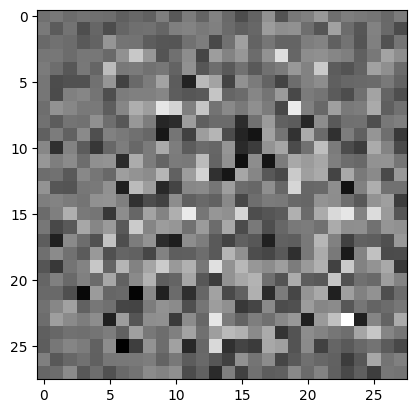

In [56]:
#example noise image
noise=tf.random.normal([1,100])
noise.shape

generator=make_generator_model()

generated_img=generator(noise, training=False)

plt.imshow(generated_img[0,:,:,:], cmap='gray')

In [90]:
def make_discriminator_model():
    model=Sequential()
    
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))   # to produce a real value
    
    return model

In [91]:
discriminator=make_discriminator_model()
decision=discriminator(generated_img, training=False)
print(decision)

tf.Tensor([[0.00238151]], shape=(1, 1), dtype=float32)


# Optimizer and loss

In [92]:
cross_entropy_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [95]:
def discriminator_loss(real_output, fake_output):
    loss_real=cross_entropy_loss(tf.ones_like(real_output), real_output)   #real must be closer to 1
    loss_fake=cross_entropy_loss(tf.zeros_like(fake_output),fake_output)   #fake must be closer to zero 
    
    return loss_real+loss_fake

In [135]:
def generator_loss(fake_output):
    loss_fake=cross_entropy_loss(tf.ones_like(fake_output), fake_output)   #fake must be closer to 1
    return loss_fake

In [99]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [108]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Model Training

In [125]:
num_samples=16
noise_dim=100
EPOCHES=50

seed=tf.random.normal([num_samples, noise_dim])

In [137]:
@tf.function
def train_step(images):
    noise=tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_images=generator(noise, training=True)
        
        real_output=discriminator(images, training=True)
        fake_output=discriminator(generated_images, training=True)
        
        generator_losss=generator_loss(fake_output)
        discriminator_losss=discriminator_loss(real_output, fake_output)
        
        gradients_of_generator=generator_tape.gradient(generator_losss, generator.trainable_variables)
        gradients_of_discriminator=discriminator_tape.gradient(discriminator_losss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))        

In [131]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start_time=time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        if((epoch+1)%15)==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print(f'time for epoch {epoch+1} is {time.time()-start_time}')
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

In [132]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
train(train_dataset, EPOCHES)